# Demo of PyTorch3D renderer for point clouds

Based on PyTorch3D official [tutorial](https://pytorch3d.org/tutorials/render_colored_points)

## Install PyTorch3D

First, [install](https://github.com/facebookresearch/pytorch3d/blob/main/INSTALL.md) `pytorch3d`. Check requirements from installation guide

Make sure you have [compatible](https://pypi.org/project/torchvision/) `torch` and `torchvision` versions

Recommended manual installation from wheels (linux), below command setups PyTorch3D for python3.8 + torch1.11.0 for cuda1.13

```
pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu113_pyt1110/download.html
```

#### The cell below can setup PyTorch3D (stable work not guaranteed)

In [ ]:
# The cell below can setup PyTorch3D (stable work not guaranteed)

import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

## Import modules

In [1]:
import os
import torch

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    PerspectiveCameras,
    OrthographicCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

## Load demo data

In [2]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Load data from folder

In [3]:
# Data for demo folder contains RGB and Depth image
# and intrinsic camera parameters (Azure Kinect)
DATA_DIR = "./data_demo"
image_filename = os.path.join(DATA_DIR, "image.jpg")
depth_filename = os.path.join(DATA_DIR, "depth.png")
intrinsic_filename = os.path.join(DATA_DIR, "intrinsic.json")

# Import images as numpy arrays
# and intrinsic parameters as 4x4 matrix
# |f_x,   0, c_x,  0|
# |  0, f_y, c_y,  0|
# |  0,   0,   1,  0|
# |  0,   0,   0,  1|
image = np.asarray(Image.open(image_filename))
depth = np.asarray(Image.open(depth_filename))
with open(intrinsic_filename) as intrinsic_file:
    intrinsic = json.load(intrinsic_file)
    intrinsic = np.block([[[np.array(intrinsic['intrinsic_matrix']).reshape(3, 3).T, np.zeros((3, 1))], [np.zeros(3), 1]]])

Plot loaded images

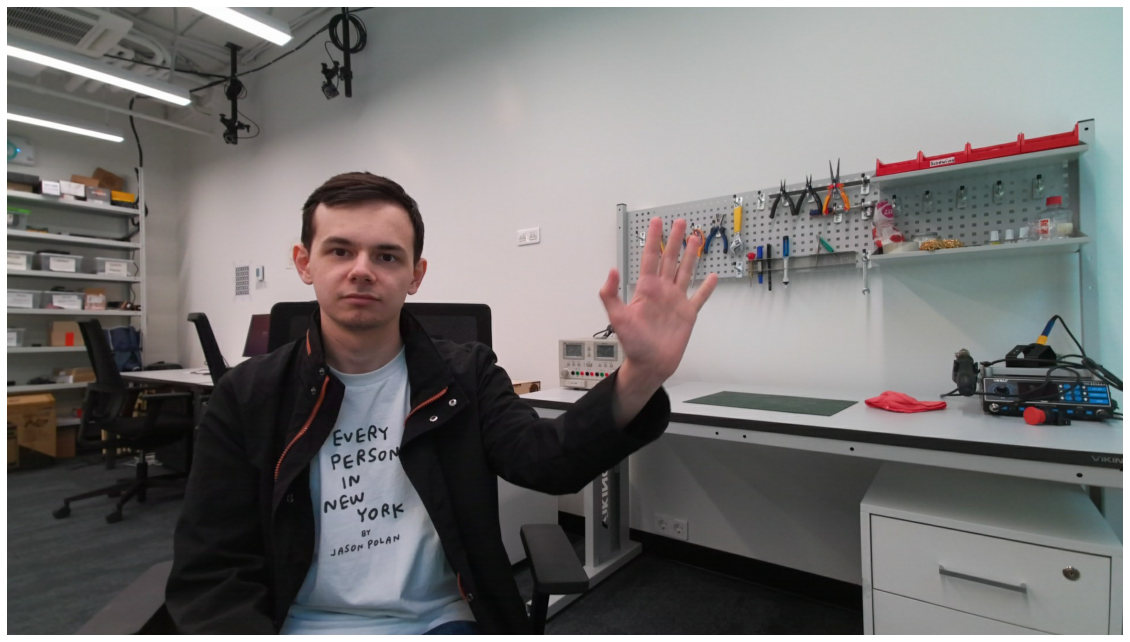

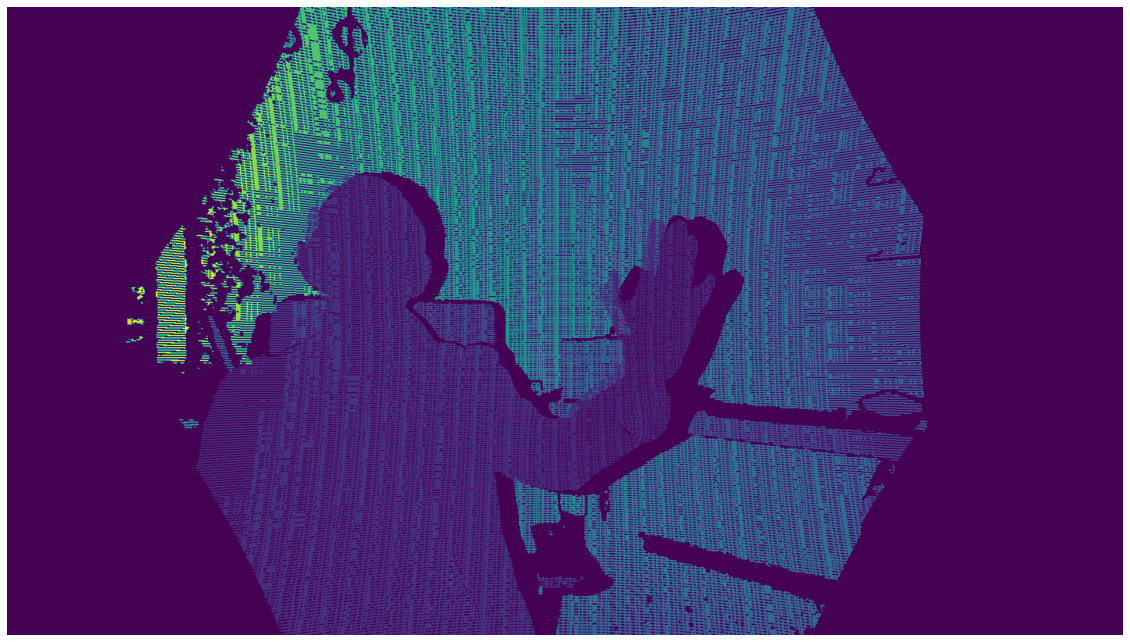

In [4]:
# RGB image
plt.figure(figsize=(20, 40))
plt.imshow(image)
plt.axis("off")

# Depth image
plt.figure(figsize=(20, 40))
plt.imshow(depth)
plt.axis("off");

## Convert RGB-D to point cloud

Function to calculate coordinates of image pixels in world frame ([source](https://codereview.stackexchange.com/questions/79032/generating-a-3d-point-cloud/84990#84990))

In [4]:
def point_coords(intrinsic, depth):
    """Transform a depth image into a point cloud with one point for each
    pixel in the image, using the camera transform for a camera
    centred at cx, cy with field of view fx, fy.

    depth is a 2-D ndarray with shape (rows, cols).
    The result is a 3-D array with shape (rows, cols, 3).
    Pixels with invalid depth in the input have
    NaN for the z-coordinate in the result.
    """
    # depth_scale actially doesn't have effect on render
    # Assumption millimetres -> metres
    depth_scale = 1000
    
    # Get intrinsic parameters
    # cy has additional -10 from manual setting for better matching
    fx = intrinsic[0, 0]
    fy = intrinsic[1, 1]
    cx = intrinsic[0, 2]
    cy = intrinsic[1, 2] - 10

    # Calculate coordinates
    rows, cols = depth.shape
    c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
    valid = (depth > 0)
    z = np.where(valid, depth / depth_scale, np.nan)
    x = np.where(valid, z * (cx - c) / fx, np.nan)
    y = np.where(valid, z * (cy - r) / fy, np.nan)
    return np.dstack((x, y, z))

Apply function to get coordinates

In [5]:
# Coordinates in shape (rows, cols, 3)
coords = point_coords(intrinsic[0], depth)

# Mask of not nan pixels (which has depth info)
mask = ~np.isnan(coords[..., -1])

# Transform coords and image to array (N, 3). N - number of points in cloud
# Normalize RGB to [0, 1], also attach column with alpha value for renderer
alpha = 0.9961
list_coords = coords[mask]
list_image = np.c_[image[mask] / 255, np.ones(np.sum(mask)) * alpha]

Create `Pointclouds` object

Inputs are nested lists of point clouds arrays ([docs](https://pytorch3d.readthedocs.io/en/latest/modules/structures.html#pytorch3d.structures.Pointclouds))

In [6]:
# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Create Point Cloud
verts = torch.Tensor(list_coords).to(device)
rgb = torch.Tensor(list_image).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])

## Render point cloud

Renderer consists of `rasterizer` and `compositor`

`rasterizer` responsible for how each point should looks like ([source](https://github.com/facebookresearch/pytorch3d/blob/a999fc22ee84b1dfefa2a2d8f9ee41e2f937d33b/pytorch3d/renderer/points/rasterizer.py#L56-L71)). `rasterizer` uses camera parameters, here is used `PerspectiveCameras`

`compositor` responsible for how to combine points located on one ray path ([source](https://github.com/facebookresearch/pytorch3d/blob/34f648ede0e52a38dfc378ad38b191ee7f1d2855/pytorch3d/renderer/points/compositor.py#L20-L39))

[1] <a href="https://arxiv.org/abs/1912.08804">SynSin: End to end View Synthesis from a Single Image.</a> Olivia Wiles, Georgia Gkioxari, Richard Szeliski, Justin Johnson. CVPR 2020.

In [8]:
# Initialize a camera
R = torch.tensor([[[1., 0., 0.],
                   [0., 1., 0.],
                   [0., 0., 1.]]])
T = torch.tensor([[0., 0., 0.]])

# Calibrated focal length to match image size
focal_length = 1.67
cameras = PerspectiveCameras(device=device, R=R, T=T, focal_length=focal_length)

# Define the settings for rasterization
# Refer to raster_points.py for explanations of these parameters
raster_settings = PointsRasterizationSettings(
    image_size=(1080, 1920), 
    radius = focal_length * 3 / 1080,
    points_per_pixel = 10
)

# Create a points renderer by compositing points using an alpha compositor
# where nearer points are weighted more heavily
# See [1] for an explanation
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

# Get image
images = renderer(point_cloud)

Plot image

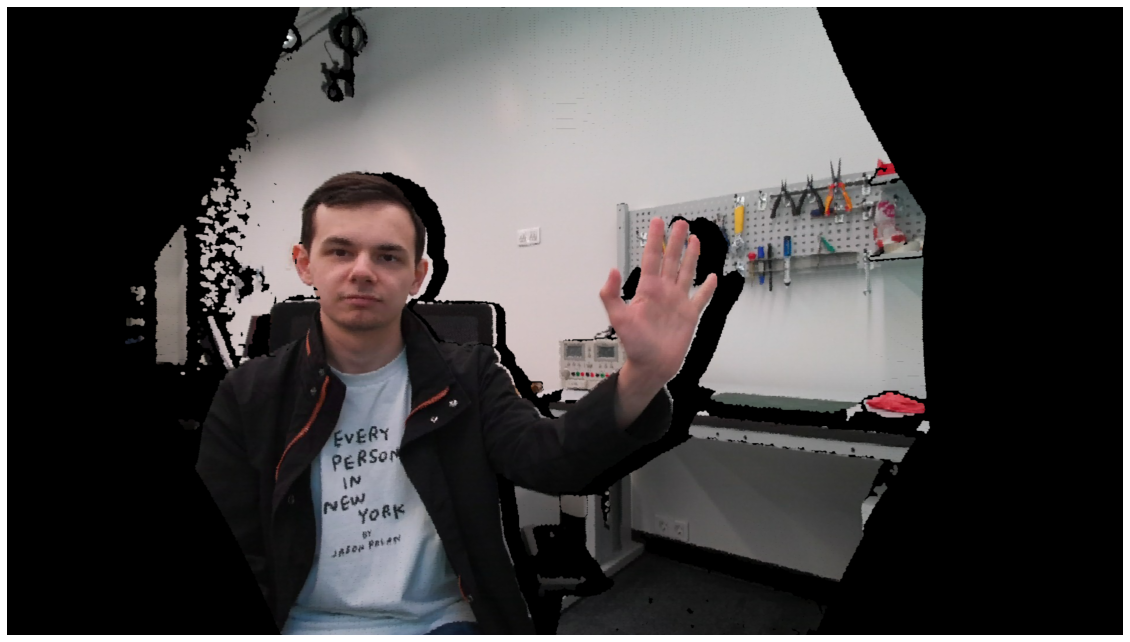

In [9]:
plt.figure(figsize=(20, 20))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

Add background on the image

In [10]:
images_back = images[0, ..., :3].cpu().numpy()
images_back = np.where(images_back == 0, image / 255, images_back)

Plot image with background

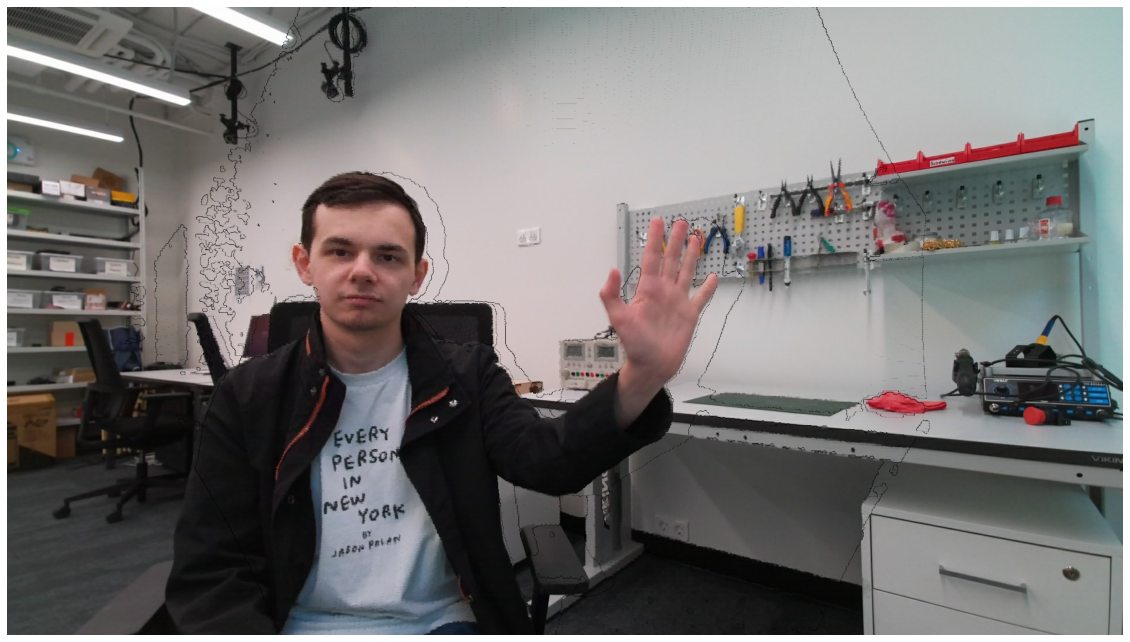

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(images_back)
plt.axis("off");

## Changing the point of view

Function `look_at_view_transform` provides `R` and `T` matrixes ([docs](https://pytorch3d.readthedocs.io/en/latest/modules/renderer/cameras.html?highlight=look_at_view_transform#pytorch3d.renderer.cameras.look_at_view_transform))

In [7]:
# Number of new images
n = 2

# Point cloud should have same batch size
point_cloud_n = Pointclouds(points=[verts]*n, features=[rgb]*n)

# Initialize a camera
R = torch.zeros(n, 3, 3)
T = torch.zeros(n, 3)

for i in range(n):
    # Transformation components (angles in degrees)
    r_dist = torch.zeros(1).uniform_(-0.2, 0.2)
    r_elev = torch.zeros(1).uniform_(-10, 10) - 20
    r_azim = torch.zeros(1).uniform_(-20, 20)

    # Save positive signs on R diag
    if r_dist > 0:
        r_azim += 180.

    # Distance, elevation, azimuth
    Ri, Ti = look_at_view_transform(dist=r_dist, elev=r_elev, azim=r_azim)

    # OR Look from (eye) -> to (at)
    # Ri, Ti = look_at_view_transform(eye=torch.tensor([[0., 0., 0.]]), at=torch.tensor([[0., -0.3, 0.5]]))
    
    R[i] = Ri
    T[i] = Ti

# Calibrated focal length to match image size
focal_length = 1.67
cameras_n = PerspectiveCameras(device=device, R=R, T=T, focal_length=focal_length)

# Define the settings for rasterization
# Refer to raster_points.py for explanations of these parameters

# Increase image size because of image shift during transform
raster_settings = PointsRasterizationSettings(
    image_size=(int(1.5*1080), int(1.5*1920)), 
    radius = focal_length * 3 / 1080,
    points_per_pixel = 10
)

# Create a points renderer by compositing points using an alpha compositor
# where nearer points are weighted more heavily
# See [1] for an explanation
rasterizer = PointsRasterizer(cameras=cameras_n, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

# Get images
images_n = renderer(point_cloud_n)

Plot new images

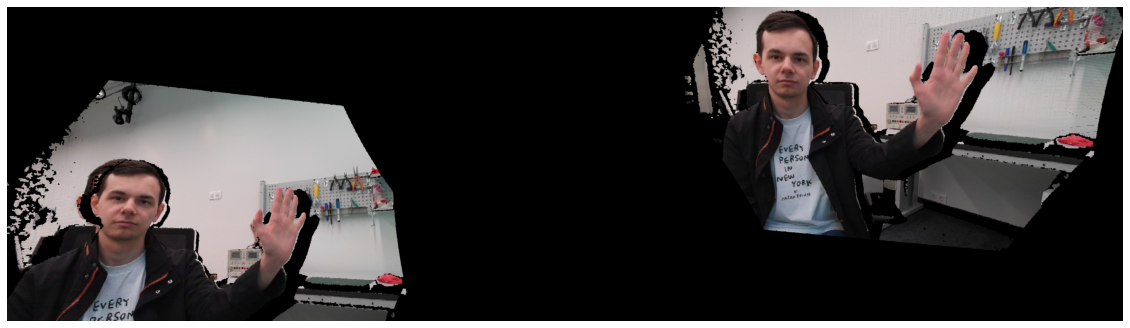

In [8]:
image_n = np.hstack([np.vstack(images_n[:n//2, ..., :3].cpu().numpy()),
                     np.vstack(images_n[n//2:, ..., :3].cpu().numpy())])
plt.figure(figsize=(20, 40))
plt.imshow(image_n)
plt.axis("off");